In [1]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

Using TensorFlow backend.


# Pre processing data

In [2]:
base = pd.read_csv('../Dataset/Training/TSLA.csv')
base = base.dropna()
base_training = base.iloc[:, 1:5].values
base_open_value = base.iloc[:, 3:4].values
base_close_value = base.iloc[:, 4:5].values

normalizer = MinMaxScaler(feature_range=(0,1))
base_training_normalized = normalizer.fit_transform(base_training)
base_open_value_normalized = normalizer.fit_transform(base_open_value)
base_close_value_normalized = normalizer.fit_transform(base_close_value)

# Adding multiple predictors

In [3]:
predictors = []
open_price = []
close_price = []

for i in range(90, 2352):
    predictors.append(base_training_normalized[i-90:i, 0:4])
    open_price.append(base_open_value_normalized[i, 0])
    close_price.append(base_close_value_normalized[i, 0])

predictors = np.array(predictors)
open_price = np.array(open_price)
close_price = np.array(close_price)

prices = np.column_stack((open_price, close_price))

# Adding classifier

In [4]:
regressor = Sequential()

# Adding the layers

In [5]:
# Adding the first LSTM layer
regressor.add(LSTM(units = 100, return_sequences = True, input_shape = (predictors.shape[1], 4)))
regressor.add(Dropout(0.3))

# Adding the second LSTM layer
regressor.add(LSTM(units = 50, return_sequences = True))
regressor.add(Dropout(0.3))

# Adding the third LSTM layer
regressor.add(LSTM(units = 50, return_sequences = True))
regressor.add(Dropout(0.3))

# Adding the fourth LSTM layer
regressor.add(LSTM(units = 50))
regressor.add(Dropout(0.3))

# Adding the output layer
regressor.add(Dense(units = 2, activation = 'linear'))

# Compiling rnn

In [6]:
regressor.compile(optimizer = 'rmsprop', loss = 'mean_squared_error')

early_stop = EarlyStopping(monitor = 'loss', min_delta = 1e-10, patience = 10, verbose = 1)
rlr = ReduceLROnPlateau(monitor = 'loss', factor = 0.2, patience = 5, verbose = 1)

regressor.fit(predictors, prices, epochs = 200, batch_size = 32,
              callbacks = [early_stop, rlr])  

Epoch 1/200
2262/2262 [==============================] - 11s 5ms/step - loss: 0.0275
Epoch 2/200
2262/2262 [==============================] - 8s 4ms/step - loss: 0.0151
Epoch 3/200
2262/2262 [==============================] - 9s 4ms/step - loss: 0.0114
Epoch 4/200
2262/2262 [==============================] - 10s 4ms/step - loss: 0.0109
Epoch 5/200
2262/2262 [==============================] - 10s 4ms/step - loss: 0.0085
Epoch 6/200
2262/2262 [==============================] - 10s 5ms/step - loss: 0.0081
Epoch 7/200
2262/2262 [==============================] - 10s 4ms/step - loss: 0.0076
Epoch 8/200
2262/2262 [==============================] - 10s 5ms/step - loss: 0.0066
Epoch 9/200
2262/2262 [==============================] - 11s 5ms/step - loss: 0.0066
Epoch 10/200
2262/2262 [==============================] - 10s 4ms/step - loss: 0.0061
Epoch 11/200
2262/2262 [==============================] - 10s 4ms/step - loss: 0.0057
Epoch 12/200
2262/2262 [==============================] - 10s 4ms

# Testing rnn

In [7]:
base_test = pd.read_csv('../Dataset/Test/TSLA.csv')
base_real_open_value = base_test.iloc[:, 3:4].values
base_real_close_value = base_test.iloc[:, 4:5].values

frames = [base, base_test]
base_complet = pd.concat(frames) 
base_complet = base_complet.drop('Date', axis = 1)

entry = base_complet[len(base_complet) - len(base_test) - 90:].values
entry = normalizer.transform(entry)

x_test = []
for i in range(90, 112):
    x_test.append(entry[i-90:i, 0:4])
x_test = np.array(x_test)

prediction = regressor.predict(x_test)
prediction = normalizer.inverse_transform(prediction)

prediction.mean()
base_real_open_value.mean()
base_real_close_value.mean()

336.17863741788

# Results

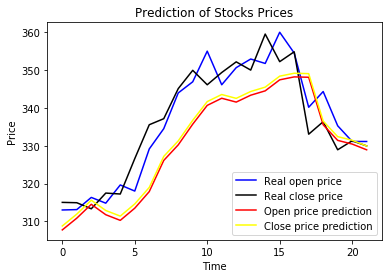

In [8]:
plt.plot(base_real_open_value, color = 'blue', label = 'Real open price')
plt.plot(base_real_close_value, color = 'black', label = 'Real close price')

plt.plot(prediction[:, 0], color = 'red', label = 'Open price prediction')
plt.plot(prediction[:, 1], color = 'yellow', label = 'Close price prediction')

plt.title('Prediction of Stocks Prices')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()